# Assignment 4

In [1]:
!pip install econml
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.formula.api as smf
from econml.dml import CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter

## 1. Predicting Heart Disease Using a Classification Tree

### 1.1 Data Cleaning

In [2]:
#Rename the variables in the following order:
#['age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd'],
#and remove missing values.
#Convert all categorical variables into dummy variables.
#Create a binary variable y that equals 1 if the person has heart disease and 0 otherwise.

names = ['age','sex','cp','restbp','chol','fbs','restecg','thalach','exang',
        'oldpeak','slope','ca','thal','hd']

df = pd.read_csv(r"../input/processed.cleveland.data",
                 header=None, names=names, na_values='?')

df = df.dropna()

df['hd'] = df['hd'].astype(int)
y = (df['hd'] > 0).astype(int)

cat = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
X = pd.get_dummies(df.drop(columns=['hd']), columns=cat, drop_first=True)
X

,age,restbp,chol,thalach,oldpeak,sex_1.0,cp_2.0,cp_3.0,cp_4.0,fbs_1.0,restecg_1.0,restecg_2.0,exang_1.0,slope_2.0,slope_3.0,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0
0,63.0,145.0,233.0,150.0,2.3,True,False,False,False,True,False,True,False,False,True,False,False,False,True,False
1,67.0,160.0,286.0,108.0,1.5,True,False,False,True,False,False,True,True,True,False,False,False,True,False,False
2,67.0,120.0,229.0,129.0,2.6,True,False,False,True,False,False,True,True,True,False,False,True,False,False,True
3,37.0,130.0,250.0,187.0,3.5,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False
4,41.0,130.0,204.0,172.0,1.4,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,140.0,241.0,123.0,0.2,False,False,False,True,False,False,False,True,True,False,False,False,False,False,True
298,45.0,110.0,264.0,132.0,1.2,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
299,68.0,144.0,193.0,141.0,3.4,True,False,False,True,True,False,False,False,True,False,False,True,False,False,True
300,57.0,130.0,131.0,115.0,1.2,True,False,False,True,False,False,False,True,True,False,True,False,False,False,True


### 1.2. Data Analysis

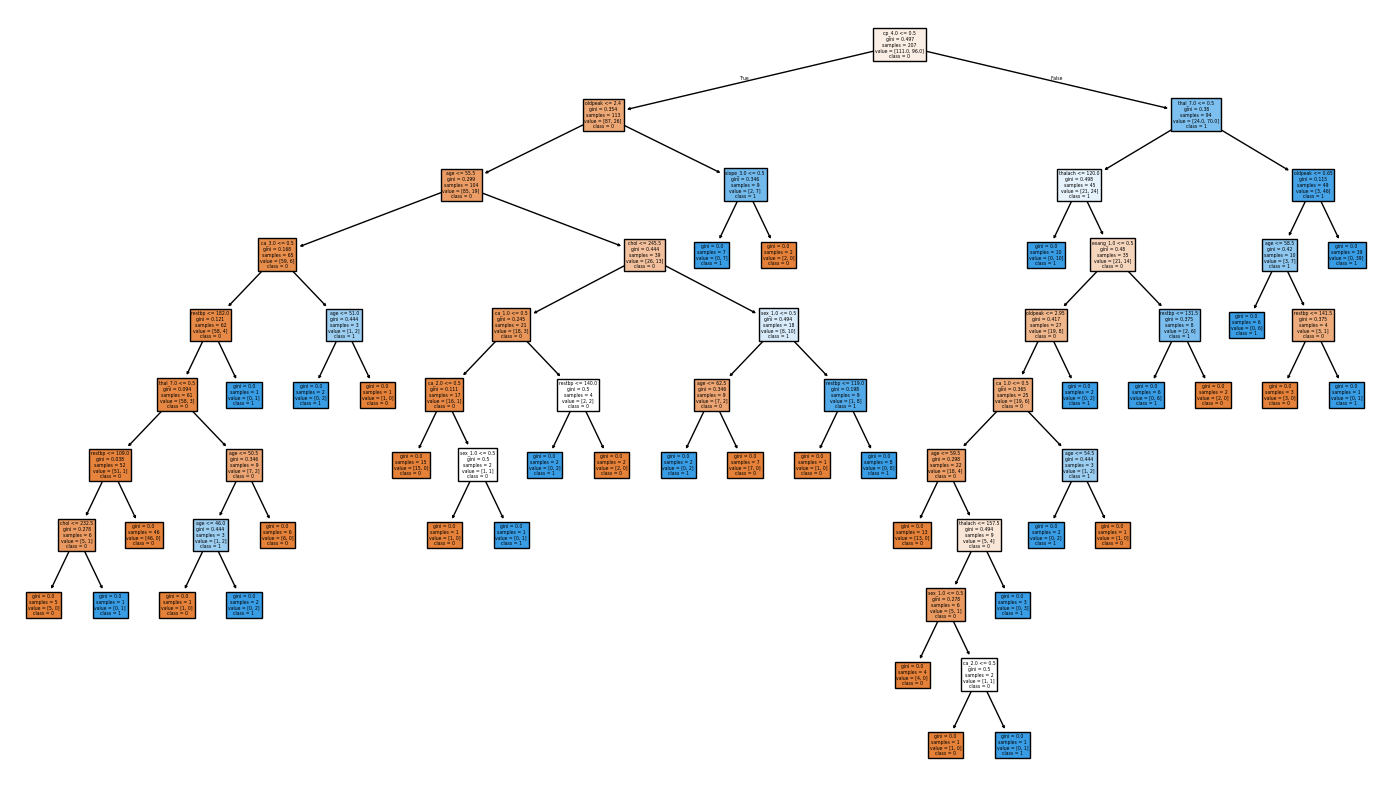

In [3]:
# Split the data into training and test sets, and plot a classification tree (random_state = 123).
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
tree0 = DecisionTreeClassifier(random_state=123).fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(14,8))
plot_tree(tree0, feature_names=X.columns, class_names=['0','1'], filled=True, ax=ax)
fig.tight_layout()
fig.savefig(r"../output/first_tree.png")
plt.show(fig)

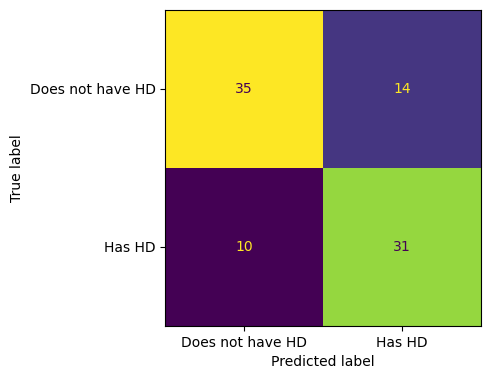

In [4]:
# Plot the confusion matrix using the labels ["Does not have HD", "Has HD"] and interpret the results.
yhat0 = tree0.predict(X_test)
cm0 = confusion_matrix(y_test, yhat0, labels=[0,1])
disp0 = ConfusionMatrixDisplay(cm0, display_labels=["Does not have HD","Has HD"])
fig, ax = plt.subplots(figsize=(5,5))
disp0.plot(ax=ax, colorbar=False)
fig.tight_layout()
fig.savefig(r"../output/first_cmatrix.png")
plt.show(fig)

### Confusion Matrix Interpretation (Positive class = “Has HD”)

- Accuracy: **(35+31)/90 ≈ 0.733**
- Precision: **31/(31+14) ≈ 0.689**
- Sensitivity: **31/(31+10) ≈ 0.756**
- Specificity: **35/(35+14) ≈ 0.714**
- False Negative Rate: **10/41 ≈ 0.244**
- False Positive Rate: **14/49 ≈ 0.286**

The model has both decent sensitivity and specificity. That is, it effectively detects most HD true cases and also identifies most cases with no HD as such. Intitively, for heart diseases, one would prefer to reduce false negatives (improve sensitivity) rather tan focusing on preventing a false positive (improving specificity). Thus, the model does relatively well.

In [5]:
# Fix the overfitting problem using ross-validation.
# Generate 50 values of α equally spaced on a logarithmic scale between e⁻¹⁰ and 0.05.
# Use 4-fold cross-validation to select the optimal alpha (random_state = 123).
alphas = np.exp(np.linspace(-10, np.log(0.05), 50))
folds = KFold(n_splits=4, shuffle=True, random_state=123)
inaccuracies = np.empty_like(alphas)

for i, a in enumerate(alphas):
    clf = DecisionTreeClassifier(ccp_alpha=a, random_state=123)
    res = cross_validate(clf, X_train, y_train, cv=folds, scoring="accuracy")
    inaccuracies[i] = 1 - res["test_score"].mean()

alpha_star = alphas[np.argmin(inaccuracies)]
print("Mejor alpha:",alpha_star)

Mejor alpha: 0.05000000000000001


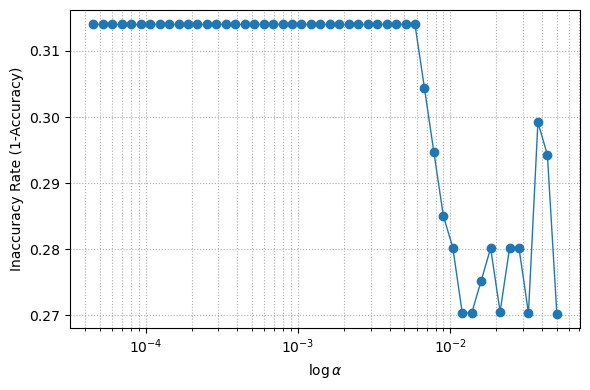

In [6]:
# Plot the Inaccuracy Rate (1 − Accuracy) against alpha.
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(alphas, inaccuracies, marker='o', linewidth=1)
ax.set_xscale('log'); ax.set_xlabel(r"$\log\alpha$"); ax.set_ylabel('Inaccuracy Rate (1-Accuracy)'); ax.grid(True, which='both', ls=':')
fig.tight_layout()
fig.savefig(r"../output/inacc_vs_alpha.png")
plt.show()

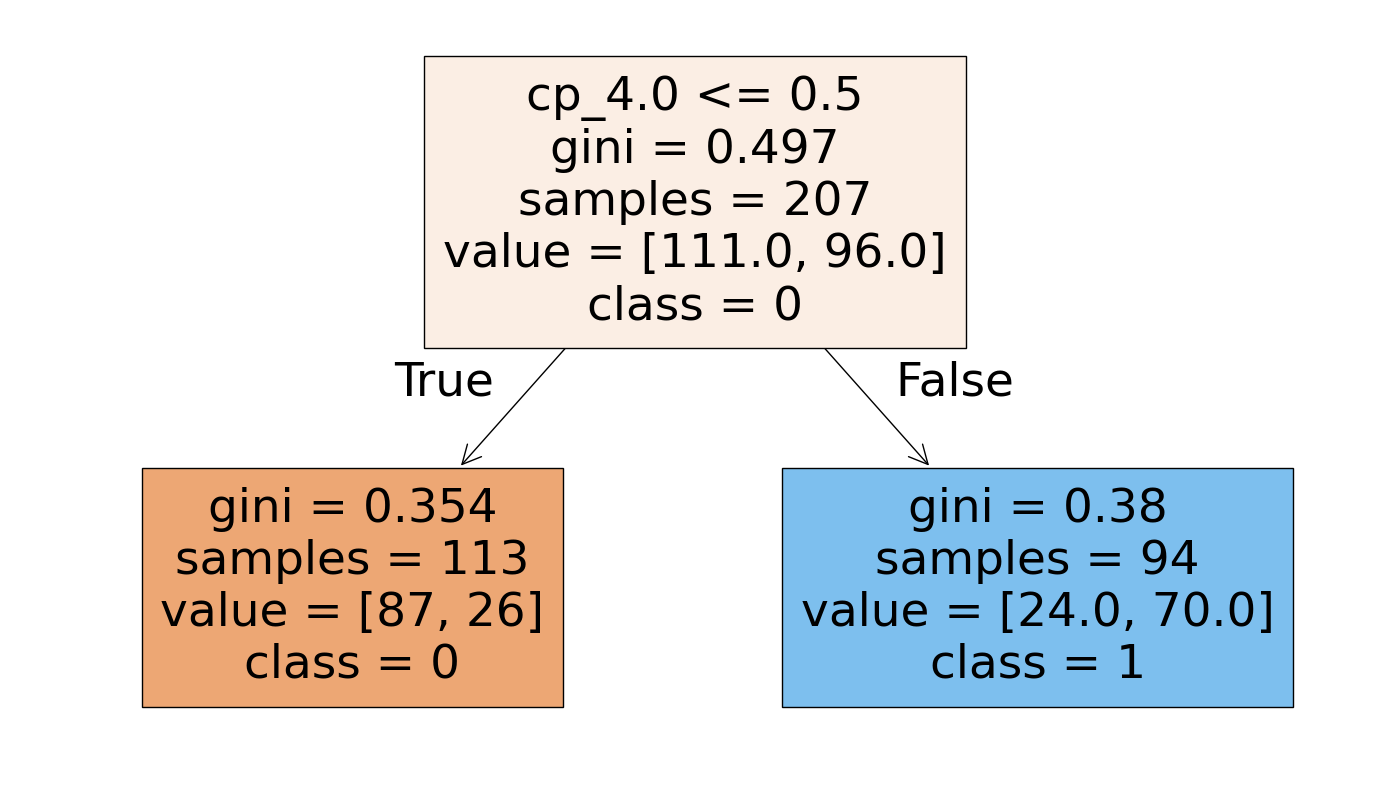

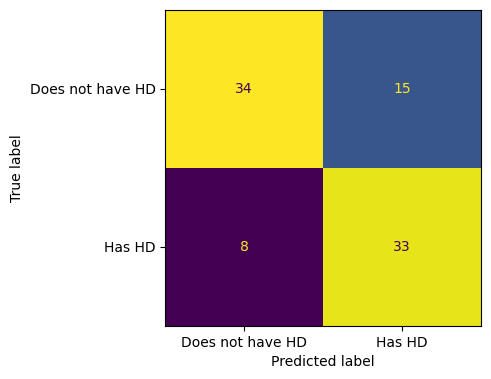

In [7]:
# Plot again the classification tree and the confusion matrix using the optimal α. Interpret and briefly discuss the results.
tree1 = DecisionTreeClassifier(random_state=123, ccp_alpha=alpha_star).fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(14,8))
plot_tree(tree1, feature_names=X.columns, class_names=['0','1'], filled=True, ax=ax)
fig.tight_layout()
fig.savefig(r"../output/final_tree.png")
plt.show(fig)

yhat1 = tree1.predict(X_test)
cm1 = confusion_matrix(y_test, yhat1, labels=[0,1])
disp1 = ConfusionMatrixDisplay(cm1, display_labels=["Does not have HD","Has HD"])
fig, ax = plt.subplots(figsize=(5,5))
disp1.plot(ax=ax, colorbar=False)
fig.tight_layout()
fig.savefig(r"../output/final_cmatrix.png")
plt.show(fig)


- Accuracy: **(34+33)/90 = 0.744**
- Precision: **33/(33+15) = 0.688**
- Sensitivity: **33/(33+8) = 0.805**
- Specificity: **34/(34+15) = 0.694**
- False Negative Rate: **8/41 = 0.195**
- False Positive Rate: **15/49 = 0.306**

The main takeaway is that the model is much more parsimonious, thanks to the tree prunning, but it still manages to perform well compared to the first model. Also, it now has a higher sensitivity, which, as discussed before, is preferable for detecting heart diseases, although it sacrifices some specificity in the process.

## 2. Causal Forest

In [8]:
# Create a binary treatment variable T that randomly takes values 0 or 1 with equal probability (simulating random assignment to the program).
np.random.seed(123)
T = np.random.binomial(1, 0.5, size=len(df))
df['T'] = T

In [9]:
# Create an outcome variable Y that measures the improvement in cardiovascular health after the program
eps = np.random.normal(size=len(df))
Y = ((1 + 0.05*df['age'] + 0.3*df['sex'] + 0.2*df['restbp'])*df['T'] + 0.5*df['oldpeak']*eps)

In [10]:
# Calculate the treatment effect on your new outcome variable 𝑌 using OLS.
ols = smf.ols('Y ~ T', df).fit()
print(ols.summary())
print('ATE:',ols.params['T'])

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 1.045e+04
Date:                Sun, 02 Nov 2025   Prob (F-statistic):          2.26e-232
Time:                        23:44:08   Log-Likelihood:                -699.22
No. Observations:                 297   AIC:                             1402.
Df Residuals:                     295   BIC:                             1410.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0637      0.211     -0.302      0.7

In [11]:
# Use a Random Forest model to estimate the causal effects.
cf = CausalForestDML(n_estimators=500, random_state=123)
cf = cf.fit(Y=Y,T=T, X=X)
cate = cf.effect(X)
print('CATE:', cate.mean())

C:\Users\buser\anaconda3\Lib\site-packages\econml\utilities.py:644: UserWarning: Not all column names are strings. Coercing to strings for now.
  warnings.warn("Not all column names are strings. Coercing to strings for now.", UserWarning)


CATE: 30.283869535799454


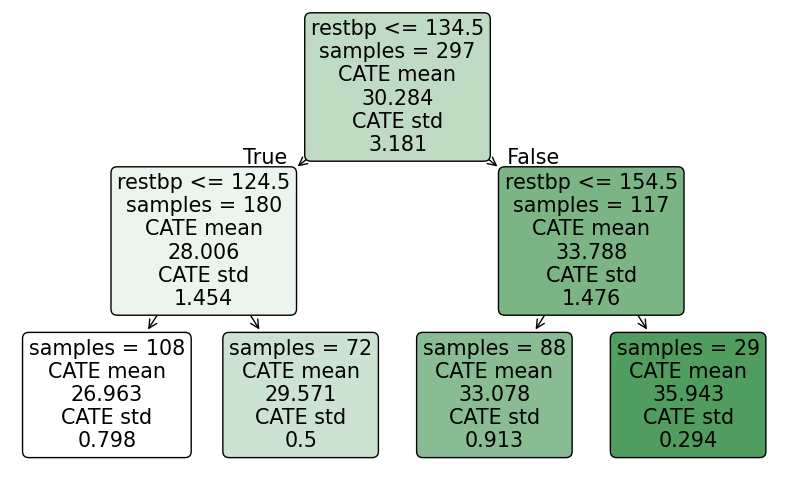

In [12]:
# Plot a representative tree that captures the most important heterogeneous treatment effects with a maximum depth of 2 (max_depth=2) and interpret it.
tree_hte = SingleTreeCateInterpreter(max_depth=2,random_state=123).interpret(cf, X)
names = X.columns.astype(str).tolist()

plt.figure(figsize=(10,6))
tree_hte.plot(feature_names=names)
plt.savefig(r"../output\hte_tree.png")
plt.show()

Given that all the splits are based on the resting blood pressure feature, this shows its importance. The tree shows that the CATE is higher (lower) within patients with higher (lower) blood pressure. The difference in the probability of having a heart disease is almost 9 p.p. between the split of patients with the lowest and highest blood pressure.

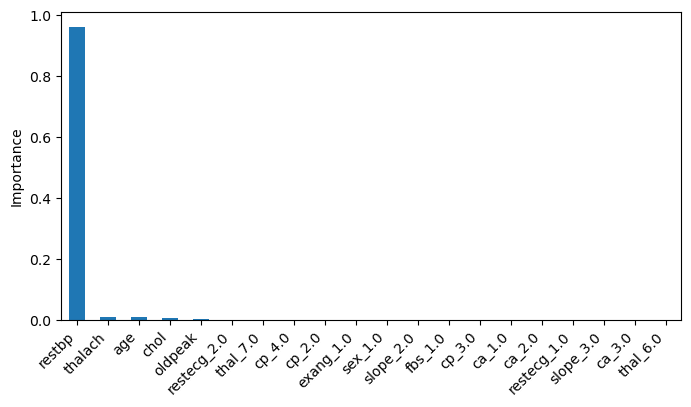

In [13]:
# Compute the feature importances and visualize them in a bar chart.
imp = pd.Series(cf.feature_importances(), index=X.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(8,4))
imp.head(20).plot(kind='bar', ax=ax)
ax.set_ylabel('Importance')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
fig.savefig(r"../output/importance.png")
plt.show()

C:\Users\buser\AppData\Local\Temp\ipykernel_2024\440702738.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = X_std.groupby(q).mean()


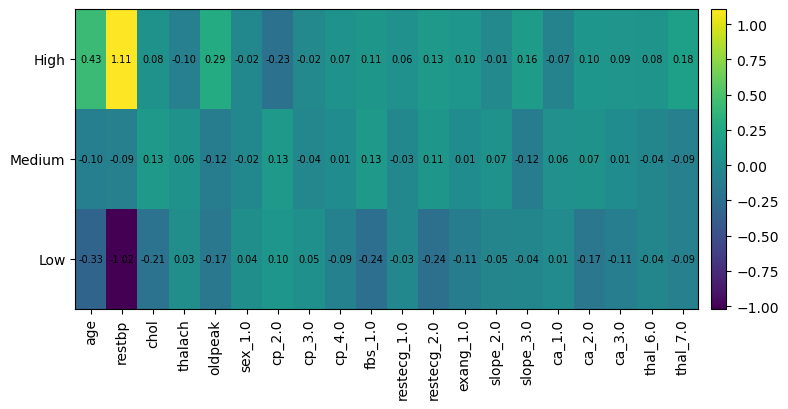

In [14]:
# Plot the distribution of standardized covariates by predicted treatment effect terciles.
X_std = (X - X.mean())/X.std(ddof=0)
q = pd.qcut(pd.Series(cate, index=X.index), 3, labels=['Low','Medium','High'])

means = X_std.groupby(q).mean()
means = means.loc[['High','Medium','Low']]
means_rounded = means.round(3)

fig, ax = plt.subplots(figsize=(min(12, 0.3*X.shape[1]+2), 4.2))
im = ax.imshow(means.values, aspect='auto')
ax.set_yticks(range(3)); ax.set_yticklabels(means.index.tolist())
ax.set_xticks(range(X.shape[1])); ax.set_xticklabels(X.columns.astype(str), rotation=90)

for i in range(means.shape[0]):
    for j in range(means.shape[1]):
        ax.text(j, i, f"{means.values[i, j]:.2f}", ha="center", va="center", fontsize=7)

fig.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
fig.tight_layout()
fig.savefig(r"../output/heatmap_covariates.png")
plt.show()